In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import six

import random
import time
import os
import gc
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torchvision

TODO:
* [x] Load data from dataset 128
* [x] Implement SEResNeXt training through clean pytorch
* [x] add loss and metric logging for all 3 groups
* [ ] Add CutMix or mixup/cutmix 1:1
* [ ] Running average weights
* [ ] Add more layers after backbone
* [ ] 100-150 epochs
 
TODO if have time:
* [ ] Think about: https://www.kaggle.com/c/bengaliai-cv19/discussion/130503
* [ ] [Watch model mistakes kernel](https://www.kaggle.com/kaerunantoka/get-classes-difficult-to-classify-for-your-model?scriptVersionId=27766417)
* [ ] Try AdamW
* [ ] Add MixUp
* [x] Add other augmentations
* [ ] Add Cosine LR
* [ ] Try different models (se_resnet101, Densenet121)
* [ ] Add Dropblock

```
> 39 place
Model: Densenet121
img_size: 3x224x224 (simple resize)
Augmentation: NOT cutmix or mixup
Epoch: 40 (still running)
CV: 0.9938
LB: 0.9825
```

```
> 11 place
model: se-resnext50
img_size: 3x137x236
augmentation: rotate, cutmix
Epoch: 80
CV : 0.994
LB: 0.985

I can not get the CV score more than 0.997 from some top kagglers. So perhaps I can get some advice and help from your guys here😃 
```

```
Model: se-resnext50-32x4d
Image size: 128x128x1
I combined augmentation methods and Cutmix is one of them
150 epochs
CV: 0.9937
LB: 0.9838

My CV : 0.5 * 0.99107(root) + 0.25 * 0.99648(vowel) + 0.25 * 0.99641(consonant) = 0.9937
```

```
model: se_resnext50_32x4d
imgsize: 128x128
split: 5/6 train, 1/6 valid
inference: 15 minutes (kaggle kernels)
no tta, no ensemble
```

```
I had another post asking people what kind of input size they use and a few people were surprised at the score I got with 64x64x1 inputs. So I decided to shared the strategy a little bit because using 64x64 is nice for people with low computing power (I only have 2x2080).
The strategy is as follows:
Single model of wide resnet with three dense layers on top (One for each class)
Dropout before each pooling layer
I used only cutout and trained for 100 epochs.
Scores:
0.97 with 0.15 validation split
0.9718 without validation
```

In [3]:
!pip install ../input/pytorch-pretrained-models/repository/pretrained-models.pytorch-master/ > /dev/null # no output

In [4]:
SEED = 1984
BATCH_SIZE = 256  # 128
NUM_EPOCHS = 35
MODEL_NAME = 'se_resnext50_32x4d'  #  'se_resnext50_32x4d'  'se_resnext101_32x4d'  # 'wide_resnet50_2'

OUT_PATH = '.'
TRAIN = '../input/bengali-crop-128x128/'
LABELS = '../input/bengaliai-cv19/train.csv'

# TRAIN = '../input/train/'
# LABELS = '../input/train.csv'

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

Custom DataSet

In [6]:
class BengaliAIDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, labels, transform=None):
        self.images_path = images_path
        self.transform = transform
        
        self.labels = labels
        self.image_names = self.labels[:, 0] + '.png'
        self.targets = self.labels[:, 1:4].astype(np.uint8)
    
    def __len__(self):
        """return length of this dataset"""
        return len(self.labels)        
    
    def get_image(self, image_name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: an image
        """
        image_path = os.path.join(self.images_path, image_name)
#         image = Image.open(image_path)
        image = cv2.imread(image_path, 0).reshape((128, 128, 1))
        return image
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = self.get_image(image_name)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        target = torch.from_numpy(self.targets[index])
        
        return (image, target)

Image transformations

In [7]:
from albumentations.augmentations.transforms import ShiftScaleRotate
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensor

# train_transform = torchvision.transforms.Compose([
#                 torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Normalize((0.0528,), (0.1629,))]) 

train_transform = Compose([
                Normalize(mean=(0.0528,), std=(0.1629,)),
                ShiftScaleRotate(p=0.5, rotate_limit=10),
                ToTensor(),
], p=1.0) 

Create train dataset with transformations

In [8]:
from sklearn.model_selection import train_test_split

labels = pd.read_csv(LABELS).to_numpy()

labels_train, labels_val = train_test_split(labels, test_size=0.15, stratify=labels[:, 1])

In [9]:
train_dataset = BengaliAIDataset(images_path=TRAIN, labels=labels_train, transform=train_transform)
val_dataset = BengaliAIDataset(images_path=TRAIN, labels=labels_val, transform=train_transform)

Create dataloader from train_dataset

In [10]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

dataloaders = {'train': loader_train, 'val': loader_val}

Check loader

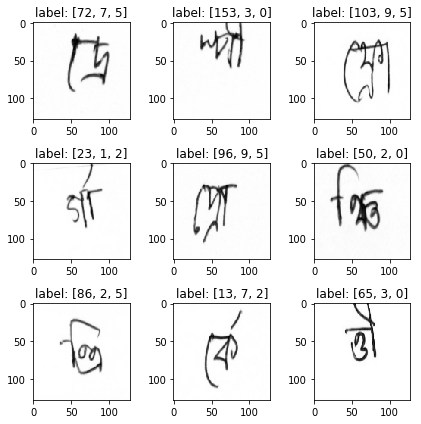

In [11]:
nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(6, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    ax.imshow(image.reshape((128, 128)), cmap='Greys')
    ax.set_title(f'label: {label.data.tolist()}')

plt.tight_layout()
plt.show()

## Model

In [12]:
import pretrainedmodels
from torch import nn
import torch.nn.functional as F

import copy
from sklearn.metrics import recall_score

In [13]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, target, reduction='mean'):
        y_pred = torch.split(y_pred, [n_grapheme, n_vowel, n_consonant], dim=1)
        y_pred = [y_pr.float() for y_pr in y_pred]
        y = target.long()
        
        loss_grapheme = F.cross_entropy(y_pred[0], y[:, 0], reduction=reduction)
        loss_vowel = F.cross_entropy(y_pred[1], y[:, 1], reduction=reduction)
        loss_consonant = F.cross_entropy(y_pred[2], y[:, 2], reduction=reduction)
        final_loss = 0.7 * loss_grapheme + 0.1 * loss_vowel + 0.2 * loss_consonant
        
        return loss_grapheme, loss_vowel, loss_consonant, final_loss

In [14]:
def eval_metric(y_pred, y_fact):
    y_pred = torch.split(y_pred, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in y_pred]

    y_fact = y_fact.cpu().numpy()

    recall_grapheme = recall_score(pred_labels[0], y_fact[:, 0], average='macro', zero_division=0)
    recall_vowel = recall_score(pred_labels[1], y_fact[:, 1], average='macro', zero_division=0)
    recall_consonant = recall_score(pred_labels[2], y_fact[:, 2], average='macro', zero_division=0)
    
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_recall = np.average(scores, weights=[2, 1, 1])

    return recall_grapheme, recall_vowel, recall_consonant, final_recall

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [16]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    history = {'train_loss_grapheme': list(), 'train_loss_vowel': list(), 'train_loss_consonant': list(), 'train_loss': list(), 
               'train_acc_grapheme': list(), 'train_acc_vowel': list(), 'train_acc_consonant': list(), 'train_acc': list(), 
               'val_loss_grapheme': list(), 'val_loss_vowel': list(), 'val_loss_consonant': list(), 'val_loss': list(), 
               'val_acc_grapheme': list(), 'val_acc_vowel': list(), 'val_acc_consonant': list(), 'val_acc': list(), 
               'lr': list(), 'time': list(), }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        current_lr = get_lr(optimizer)
        try:
            if current_lr < history['lr'][-1]:
                print("LR reduced from {} to {}".format(history['lr'][-1], current_lr))
        except:
            pass
        history['lr'].append(current_lr)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running = {k: 0.0 for k in history.keys()}

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
 
                    outputs = model(inputs)
                    loss_grapheme, loss_vowel, loss_consonant, loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                recall_grapheme, recall_vowel, recall_consonant, final_recall = eval_metric(outputs, labels)
                
                running['{}_loss_grapheme'.format(phase)] += loss_grapheme.item()
                running['{}_loss_vowel'.format(phase)] += loss_vowel.item()
                running['{}_loss_consonant'.format(phase)] += loss_consonant.item()
                running['{}_loss'.format(phase)] += loss.item()
                
                running['{}_acc_grapheme'.format(phase)] += recall_grapheme
                running['{}_acc_vowel'.format(phase)] += recall_vowel
                running['{}_acc_consonant'.format(phase)] += recall_consonant
                running['{}_acc'.format(phase)] += final_recall

            for k in history.keys():
                if phase in k:
                    history[k].append(running[k] / len(dataloaders[phase]))
            
            epoch_loss = history['{}_loss'.format(phase)][-1]
            epoch_acc = history['{}_acc'.format(phase)][-1]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            


        scheduler.step(epoch_loss)
        history['time'].append((time.time() - epoch_start) / 60)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

> Всем привет. Как вы работаете с размером картинок, который не соответствует размеру, на котором обучались сетки? Вы убираете слои, чтобы картинка не свернулась в тензор с отрицательными Height/Width измерениями? Или есть более хороший способ?

> AdaptiveAvgPool вместо обычного

In [17]:
class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

In [18]:
# def get_model(model_name='se_resnext101_32x4d', n_out=186, pretrained='imagenet'):
#     if model_name.startswith('se_resnext'):
#         model = pretrainedmodels.__dict__[model_name](pretrained=None)
# #         model = pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained=None)
#         pretrained_path = os.popen("find ../input/pytorch-pretrained-models -iname {}*".format(model_name)).read().strip()
#         model.load_state_dict(torch.load(pretrained_path))

#         model.layer0.conv1.in_channels = 1
#         model.layer0.conv1.weight.data = model.layer0.conv1.weight.mean(dim=1, keepdim=True)

#         model.avg_pool = nn.AvgPool2d(kernel_size=4, stride=1)
#         model.last_linear = nn.Linear(in_features=2048, out_features=n_out, bias=True)
#     elif model_name.startswith('wide_resnet'):
#         model = torch.hub.load('pytorch/vision:v0.5.0', 'wide_resnet50_2', pretrained=True)
        
#         model.conv1.in_channels = 1
#         model.conv1.weight.data = model.conv1.weight.mean(dim=1, keepdim=True)
        
#         model.maxpool = nn.AdaptiveMaxPool2d((112, 112))
#         model.fc = nn.Linear(in_features=2048, out_features=n_out, bias=True)
#     else:
#         raise Exception
#     return model

In [19]:
class SERES(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d', n_out=186, drop_prob=0.1):
        super(SERES, self).__init__()
        model = pretrainedmodels.__dict__[model_name](pretrained=None)
        pretrained_path = os.popen("find ../input/pytorch-pretrained-models -iname {}*".format(model_name)).read().strip()
        model.load_state_dict(torch.load(pretrained_path))
        
        self.layer0 = model.layer0
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

        self.dropblock0 = DropBlock2D(drop_prob=drop_prob, block_size=7)
        self.dropblock1 = DropBlock2D(drop_prob=drop_prob, block_size=5)
        self.dropblock2 = DropBlock2D(drop_prob=drop_prob, block_size=3)
        self.dropblock3 = DropBlock2D(drop_prob=drop_prob, block_size=3)
        self.dropout = nn.Dropout(drop_prob)
        
#         self.avg_pool = nn.AvgPool2d(kernel_size=4, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.last_linear = nn.Linear(in_features=2048, out_features=n_out, bias=True)
        
        self.flatten = nn.Flatten()
        
        self.layer0.conv1.in_channels = 1
        self.layer0.conv1.weight.data = self.layer0.conv1.weight.mean(dim=1, keepdim=True)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.dropblock0(x)
        
        x = self.layer1(x)
        x = self.dropblock1(x)
        
        x = self.layer2(x)
        x = self.dropblock2(x)
        
        x = self.layer3(x)
        x = self.dropblock3(x)
        
        x = self.layer4(x)
    
        x = self.avg_pool(x)
      
        x = self.flatten(x)

        x = self.dropout(x)
        
        out = self.last_linear(x)
        
        return out

In [20]:
def get_optimizer(model_name='se_resnext101_32x4d'):
    if model_name.startswith('se_resnext'):
        optimizer = torch.optim.Adam(
            [
                {"params": model.layer0.parameters()},
                {"params": model.layer1.parameters()},
                {"params": model.layer2.parameters()},
                {"params": model.layer3.parameters()},
                {"params": model.layer4.parameters()},
                {"params": model.last_linear.parameters(), "lr": 0.005},
            ],
            lr=0.001,
        )
    elif model_name.startswith('wide_resnet'):
        optimizer = torch.optim.Adam(
            [
                {"params": model.conv1.parameters()},
                {"params": model.bn1.parameters()},
                {"params": model.layer1.parameters()},
                {"params": model.layer2.parameters()},
                {"params": model.layer3.parameters()},
                {"params": model.layer4.parameters()},
                {"params": model.fc.parameters(), "lr": 0.005},
            ],
            lr=0.001,
        )
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return optimizer

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

model = SERES(model_name=MODEL_NAME, n_out=n_total)
model = model.to(device)

In [22]:
model

SERES(
  (layer0): Sequential(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
     

In [23]:
grad_params = list()
for name, param in model.named_parameters():
    if param.requires_grad == True:
#         print(name)
        grad_params.append(name)
print("N params:", len(grad_params))

N params: 225


In [24]:
optimizer = get_optimizer(MODEL_NAME)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-10)

In [25]:
criterion = Loss_combine()

In [26]:
# CHECKING

# phase = 'val'
# for inputs, labels in dataloaders[phase]:
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     optimizer.zero_grad()

#     for m in [model, model_trained]:
#         outputs = m(inputs)
#         loss = criterion(outputs, labels)

#         running_loss = loss.item() #* inputs.size(0)
#         running_corrects = eval_metric(outputs, labels)

#         print('loss', running_loss)
#         print('metric', running_corrects)
#     break

In [27]:
# Train and evaluate
model, hist = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Epoch 1/35
----------
train Loss: 1.0209 Acc: 0.6880
val Loss: 0.3181 Acc: 0.8917

Epoch 2/35
----------
train Loss: 0.4231 Acc: 0.8552
val Loss: 0.2329 Acc: 0.9187

Epoch 3/35
----------
train Loss: 0.3391 Acc: 0.8831
val Loss: 0.2139 Acc: 0.9261

Epoch 4/35
----------
train Loss: 0.2949 Acc: 0.8976
val Loss: 0.1906 Acc: 0.9348

Epoch 5/35
----------
train Loss: 0.2661 Acc: 0.9058
val Loss: 0.1839 Acc: 0.9336

Epoch 6/35
----------
train Loss: 0.2456 Acc: 0.9117
val Loss: 0.1569 Acc: 0.9445

Epoch 7/35
----------
train Loss: 0.2264 Acc: 0.9185
val Loss: 0.1539 Acc: 0.9455

Epoch 8/35
----------
train Loss: 0.2116 Acc: 0.9233
val Loss: 0.1496 Acc: 0.9447

Epoch 9/35
----------
train Loss: 0.2007 Acc: 0.9276
val Loss: 0.1429 Acc: 0.9496

Epoch 10/35
----------
train Loss: 0.1915 Acc: 0.9292
val Loss: 0.1446 Acc: 0.9491

Epoch 11/35
----------
train Loss: 0.1834 Acc: 0.9323
val Loss: 0.1474 Acc: 0.9487

Epoch 12/35
----------
train Loss: 0.1776 Acc: 0.9341
val Loss: 0.1381 Acc: 0.9507

E

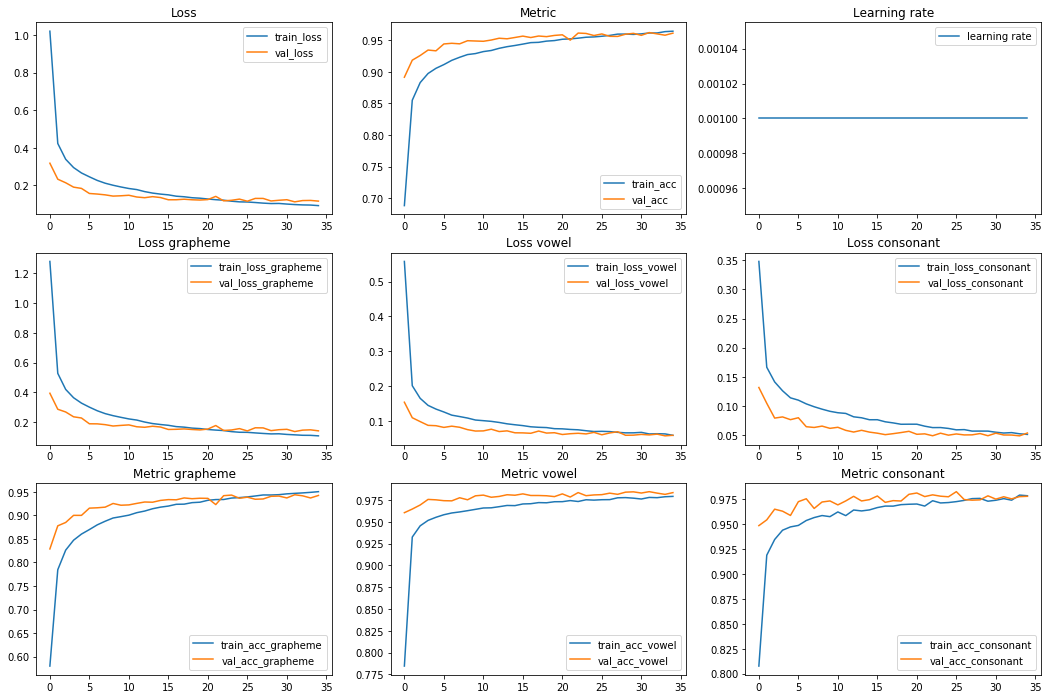

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for phase in ['train', 'val']:
    axes[0, 0].plot(hist[f'{phase}_loss'], label=f'{phase}_loss');
    axes[0, 1].plot(hist[f'{phase}_acc'], label=f'{phase}_acc');
axes[0, 2].plot(hist['lr'], label='learning rate');

axes[0, 0].set_title("Loss");
axes[0, 1].set_title("Metric");
axes[0, 2].set_title("Learning rate");

for i, part in enumerate(['grapheme', 'vowel', 'consonant']):
    for phase in ['train', 'val']:
        axes[1, i].plot(hist[f'{phase}_loss_{part}'], label=f'{phase}_loss_{part}');
        axes[2, i].plot(hist[f'{phase}_acc_{part}'], label=f'{phase}_acc_{part}');
    axes[1, i].set_title(f"Loss {part}");
    axes[2, i].set_title(f"Metric {part}");

for ax in axes.flatten():
    ax.legend();

In [29]:
df = pd.DataFrame(hist)
df.to_csv('./hist.csv')
df

,train_loss_grapheme,train_loss_vowel,train_loss_consonant,train_loss,train_acc_grapheme,train_acc_vowel,train_acc_consonant,train_acc,val_loss_grapheme,val_loss_vowel,val_loss_consonant,val_loss,val_acc_grapheme,val_acc_vowel,val_acc_consonant,val_acc,lr,time
0,1.279289,0.557959,0.348136,1.020926,0.579835,0.784548,0.807694,0.687978,0.394739,0.153904,0.131789,0.318065,0.828734,0.960587,0.948648,0.891676,0.001,19.054888
1,0.528111,0.201330,0.166512,0.423113,0.784532,0.932620,0.918984,0.855167,0.287212,0.109386,0.104640,0.232915,0.877831,0.964754,0.954424,0.918710,0.001,13.648572
2,0.420487,0.165062,0.141310,0.339109,0.826158,0.945506,0.934721,0.883136,0.268952,0.098289,0.079251,0.213946,0.884945,0.969418,0.965143,0.926113,0.001,13.541594
3,0.364536,0.144805,0.126122,0.294880,0.847300,0.951752,0.944044,0.897599,0.236628,0.087512,0.081259,0.190642,0.900082,0.975825,0.963136,0.934781,0.001,13.498527
4,0.328329,0.134219,0.114022,0.266057,0.860299,0.955314,0.947355,0.905817,0.228506,0.086509,0.076569,0.183919,0.900018,0.975343,0.958851,0.933558,0.001,13.534860
5,0.301469,0.125884,0.110051,0.245627,0.869861,0.958239,0.948842,0.911701,0.189679,0.081627,0.079859,0.156910,0.915398,0.974362,0.972662,0.944455,0.001,13.475586
6,0.277138,0.116775,0.103648,0.226403,0.879908,0.960263,0.953775,0.918463,0.189215,0.085158,0.064464,0.153859,0.916141,0.974173,0.975600,0.945514,0.001,13.507648
7,0.257920,0.112735,0.098743,0.211566,0.887582,0.961444,0.956723,0.923333,0.183928,0.081992,0.063173,0.149583,0.917502,0.977730,0.965883,0.944654,0.001,13.483328
8,0.244166,0.108453,0.094564,0.200675,0.894439,0.962887,0.958751,0.927629,0.174745,0.075206,0.065508,0.142943,0.925311,0.975398,0.972344,0.949591,0.001,13.443813
9,0.232897,0.102801,0.090892,0.191487,0.897355,0.964425,0.957650,0.929196,0.178849,0.071161,0.061653,0.144641,0.921588,0.979959,0.973411,0.949136,0.001,13.482518


In [30]:
model_path = os.path.join(OUT_PATH, 'seresnext_v0.1.pt')
torch.save(model.state_dict(), model_path)